## Introduction
This example notebook provides additional corrections to account for local shading effects from trees or buildings on top of Solcast's estimated PV power output of your rooftop site.

It requires rooftop measurements, Solcast estimates, and a Solcast API key. 

This notebook does not provide QC for your rooftop measurements, poor quality measurements will impact the quality of the output.

Correction factors are calculated for different solar position, as specified by solar zenith and azimuth returned by the Solcast API. Factors are calculated as the multiplicative bias between Solcast's estimate and the measurements for solar azimuth and zenith bins, and can be stored for later use. 

These corrections are then applied to the Solcast estimate. The notebook displays the corrected estimate and some brief error analysis.

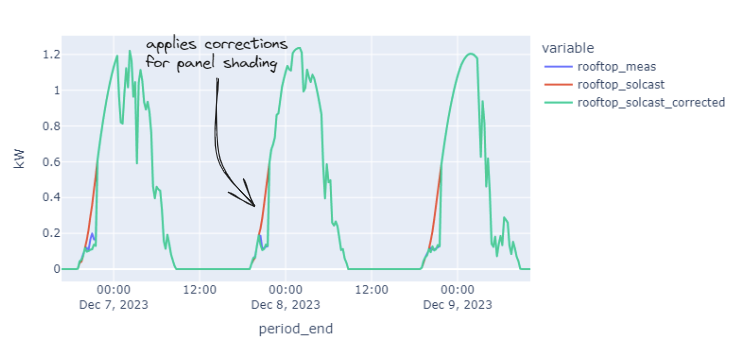

### Imports and Functions

In [1]:
# !pip install solcast plotly
# !pip install -U kaleido

In [2]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

import solcast

pd.set_option("display.max_columns", 30)
pd.set_option("display.max_rows", 300)

# leave commented out to get interactive html plots
# import plotly.io
# plotly.io.renderers.default = "png"

In [3]:
def calc_stats(obs: pd.Series, est: pd.Series) -> dict:
    """Calculate error statistics for estimates vs measurements"""

    obs = obs.dropna()
    est = est.reindex(obs.index)
    if est.isnull().any():
        raise RuntimeError(est.loc[est.isnull()])

    obs_mean = obs.mean()
    diff = est - obs

    stats = {
        "start": obs.index.min().strftime("%Y-%m-%d %H:%M"),
        "end": obs.index.max().strftime("%Y-%m-%d %H:%M"),
        "bias%": diff.mean() / obs_mean * 100,
        "mae%": diff.abs().mean() / obs_mean * 100,
        "rmse%": np.sqrt(np.mean(diff**2)) / obs_mean * 100,
        "r": pd.concat([est, obs], axis=1).corr().iloc[0].iloc[1],
        "stddev": np.sqrt(np.mean(np.square(diff - np.mean(diff)))),
    }

    return stats


def group_zen_azi_bins(
    latitude: float,
    longitude: float,
    df: pd.DataFrame,
    period: str,
):
    """Takes measurements from a site and makes an api call to find the solar zenith and azimuth. Returns input df with the zenith and azimuth,
    what bin they fall into, and the bin labels"""
    df = df.copy()
    zenith_bins = np.arange(0, 96, 5)
    azi_bins = np.arange(-135, 136, 10)
    zen_labels = [(l + r) / 2 for l, r in zip(zenith_bins[:-1], zenith_bins[1:])]
    azi_labels = [(l + r) / 2 for l, r in zip(azi_bins[:-1], azi_bins[1:])]

    # fetch zenith and azimuth values from the api
    solar_pos_df = (
        solcast.historic.radiation_and_weather(
            latitude=latitude,
            longitude=longitude,
            start=full_df.index.min(),
            end=full_df.index.max(),
            output_parameters=["azimuth", "zenith"],
            period=period,
            api_key=api_key,
        )
        .to_pandas()
        .tz_convert(None)
    )
    df["zenith"] = solar_pos_df["zenith"]
    df["azimuth"] = solar_pos_df["azimuth"]

    df["zenith_bin"] = pd.cut(df["zenith"], zenith_bins, labels=zen_labels).astype(
        float
    )
    df["azi_bin"] = pd.cut(df["azimuth"], azi_bins, labels=azi_labels).astype(float)

    return df, zen_labels, azi_labels


def calculate_rooftop_shading_corrections(
    latitude: float,
    longitude: float,
    df: pd.DataFrame,
    meas_col: str,
    solcast_col: str,
    period: str,
    api_key: str,
) -> pd.DataFrame:
    """Takes a dataframe containing rooftop measurements and a tuned Solcast estimate and calculates the correction factor for terrain shading from objects
    such as trees or buildings. Displays these corrections as a heatmap in zenith-azimuth space.
    """

    df = df.copy()

    df, zen_labels, azi_labels = group_zen_azi_bins(latitude, longitude, df, period)

    # get the residual error by finding the factor between meas and solcast
    df["factor"] = df[meas_col] / df[solcast_col]

    # only take the factors on near clearsky days
    df["cloud_opacity"] = (
        solcast.historic.radiation_and_weather(
            latitude=latitude,
            longitude=longitude,
            start=df.index.min(),
            end=df.index.max(),
            output_parameters=["cloud_opacity"],
            period=period,
            api_key=api_key,
        )
        .to_pandas()
        .tz_convert(None)
    )
    df["clearsky"] = df["cloud_opacity"] < 20
    df.loc[~df["clearsky"], "factor"] = np.nan

    # group factors into zenith and azimuth bins
    factor = df.groupby(["zenith_bin", "azi_bin"])["factor"].agg(["mean", "count"])

    # display a heatmap of the bin counts
    bin_counts_hm = (
        factor[["count"]]
        .reset_index()
        .set_index(["zenith_bin", "azi_bin"])["count"]
        .unstack()
    )
    display(
        px.imshow(
            bin_counts_hm,
            x=bin_counts_hm.columns,
            y=bin_counts_hm.index,
            title="Bin Counts",
            height=500,
            width=650,
        )
    )

    # remove bins populated by only a small number of instances
    factor.loc[factor["count"] < 10, "mean"] = np.nan
    # remove bins with divivde by 0
    factor.loc[~np.isfinite(factor["mean"]), "mean"] = 1.0
    factor = factor.reset_index()

    correction_coeffs = (
        factor.set_index(["zenith_bin", "azi_bin"])["mean"].unstack().round(3)
    )
    # display a heatmap of the correction coefficients
    display(
        px.imshow(
            correction_coeffs,
            x=correction_coeffs.columns,
            y=correction_coeffs.index,
            title="Rooftop PV Power Correction Factor",
            height=500,
            width=650,
        )
    )

    return correction_coeffs


def apply_rooftop_shading_corrections(
    latitude: float,
    longitude: float,
    df: pd.DataFrame,
    correction_coeffs: pd.DataFrame,
    meas_col: str,
    solcast_col: str,
    period: str,
    api_key: str,
) -> pd.DataFrame:
    """Takes a dataframe with rooftop power measurements and a tuned Solcast estimate. Applies the previously calculation shading correction factors to the tuned
    Solcast estimate. Returns a dataframe with the supplied measurements, uncorrected estimate and the corrected estimate.
    """

    df = df.copy()
    df, zen_labels, azi_labels = group_zen_azi_bins(latitude, longitude, df, period)

    correction_coeffs = correction_coeffs.stack().to_dict()
    df["corr_coeff"] = df.apply(
        lambda row: correction_coeffs.get((row["zenith_bin"], row["azi_bin"]), np.nan),
        axis=1,
    )

    # only apply on near clearsky days
    df["cloud_opacity"] = (
        solcast.historic.radiation_and_weather(
            latitude=latitude,
            longitude=longitude,
            start=df.index.min(),
            end=df.index.max(),
            output_parameters=["cloud_opacity"],
            period=period,
            api_key=api_key,
        )
        .to_pandas()
        .tz_convert(None)
    )
    df["clearsky"] = df["cloud_opacity"] < 20
    df[f"{solcast_col}_corrected"] = np.where(
        df["clearsky"], df[solcast_col] * df["corr_coeff"], df[solcast_col]
    )

    # where there is no correction coeff, set corrected estimate to uncorrected estimate
    df.loc[~np.isfinite(df["corr_coeff"]), f"{solcast_col}_corrected"] = df.loc[
        ~np.isfinite(df["corr_coeff"]), solcast_col
    ]

    # error analysis
    df["uncorrected mae"] = abs(df[meas_col] - df[solcast_col])
    df["corrected mae"] = abs(df[meas_col] - df[f"{solcast_col}_corrected"])

    # create a plot with both power and error
    power_cols = [meas_col, solcast_col, f"{solcast_col}_corrected"]
    error_cols = ["uncorrected mae", "corrected mae"]

    df_power = df.reset_index().melt(
        id_vars="period_end",
        value_vars=power_cols,
        var_name="source",
        value_name="power_val",
    )
    df_error = df.reset_index().melt(
        id_vars="period_end",
        value_vars=error_cols,
        var_name="source",
        value_name="error_val",
    )
    df_power["category"] = "power"
    df_error["category"] = "error"
    plot_df = pd.concat((df_power, df_error)).set_index("period_end")

    fig = px.line(
        plot_df,
        color="source",
        facet_row="category",
        title="Rooftop PV Estimate Corrected for Shading",
        height=800,
    )
    fig.update_yaxes(title_text="kW", row=1, col=1)
    fig.update_yaxes(title_text="kW", row=2, col=1)
    fig.show()

    pre_corr_stats = pd.DataFrame(
        calc_stats(df[meas_col], df[solcast_col]), index=["pre_corrected"]
    ).round(2)[["bias%", "mae%", "rmse%", "r", "stddev"]]

    corr_stats = pd.DataFrame(
        calc_stats(df[meas_col], df[f"{solcast_col}_corrected"]), index=["corrected"]
    ).round(2)[["bias%", "mae%", "rmse%", "r", "stddev"]]
    stats_table = pd.concat((pre_corr_stats, corr_stats), axis=0)
    display(stats_table)

    return df[power_cols]

### Input Data

The input data should contain rooftop measurements in kW and a tuned Solcast estimate. How to get a Solcast tuned estimate can be found in 3.4

In [4]:
full_df = pd.read_csv(
    "https://solcast.github.io/solcast-api-python-sdk/notebooks/data/3.4b_sample_measurements.csv",
    index_col=[0],
    parse_dates=True,
)  # in kW

longitude = 151.209295
latitude = -33.86882

period = "PT15M"

meas_col = "rooftop_meas"
solcast_col = "rooftop_solcast"

api_key = os.environ["API_KEY"]

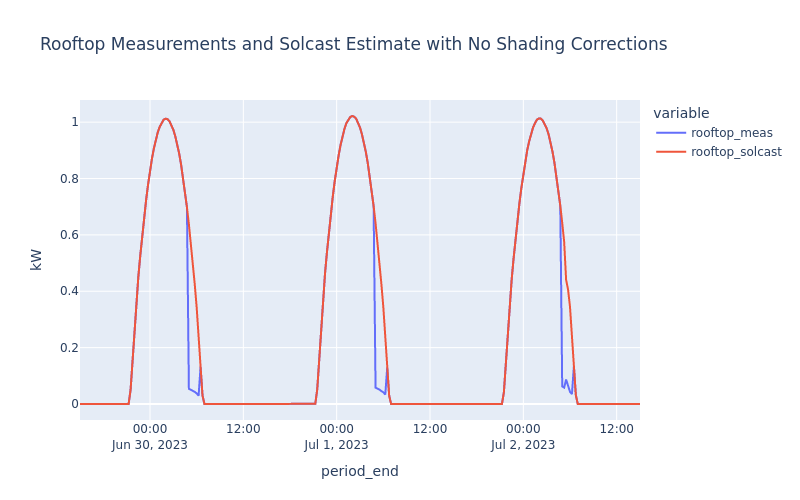

In [5]:
fig = px.line(
    full_df.loc["2023-06-29T15:00":"2023-07-02T15:00"],
    title="Rooftop Measurements and Solcast Estimate with No Shading Corrections",
    height=500,
    width=800,
)
fig.update_yaxes(title_text="kW")
fig.show()

### Calculate and display the correction coefficients

This stage calculates the correction coefficients. These can be stored and applied later.

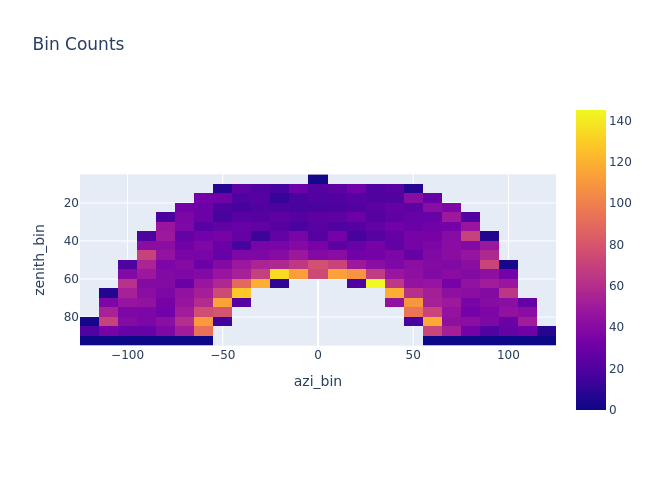

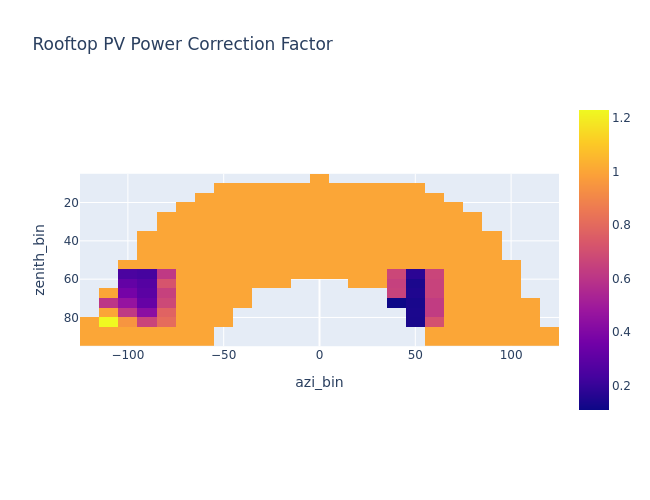

azi_bin,-120.0,-110.0,-100.0,-90.0,-80.0,-70.0,-60.0,-50.0,-40.0,-30.0,-20.0,-10.0,0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0,110.0,120.0
zenith_bin,,,,,,,,,,,,,,,,,,,,,,,,,
7.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17.5,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN
22.5,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.000,1.000,1.0,NaN,NaN,NaN,NaN,NaN
27.5,NaN,NaN,NaN,NaN,1.000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.000,1.000,1.0,1.0,NaN,NaN,NaN,NaN
32.5,NaN,NaN,NaN,NaN,1.000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.000,1.000,1.0,1.0,NaN,NaN,NaN,NaN
37.5,NaN,NaN,NaN,1.000,1.000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.000,1.000,1.0,1.0,1.0,NaN,NaN,NaN
42.5,NaN,NaN,NaN,1.000,1.000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.000,1.000,1.0,1.0,1.0,NaN,NaN,NaN
47.5,NaN,NaN,NaN,1.000,1.000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.000,1.000,1.0,1.0,1.0,NaN,NaN,NaN


In [6]:
coeffs = calculate_rooftop_shading_corrections(
    latitude=latitude,
    longitude=longitude,
    df=full_df.loc["2023-01-01":"2023-12-31"],
    meas_col=meas_col,
    solcast_col=solcast_col,
    period=period,
    api_key=api_key,
)


coeffs.reset_index().to_csv("Rooftop_correction_coefficients.csv", index=False)
coeffs

## Apply the correction coefficients

Get a Solcast corrected estimate and some brief error analysis

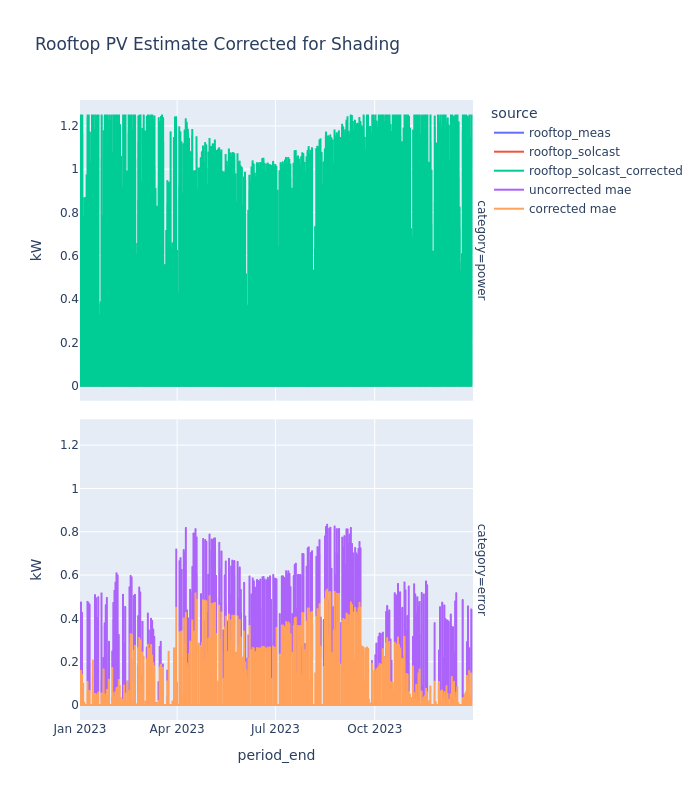

,bias%,mae%,rmse%,r,stddev
pre_corrected,5.10,5.11,29.75,0.98,0.08
corrected,0.27,2.36,14.33,1.00,0.04


In [7]:
# Read back in the coefficients and make sure format is corect
coeffs = pd.read_csv("Rooftop_correction_coefficients.csv", index_col=["zenith_bin"])
coeffs.columns.name = "azi_bin"
coeffs.columns = pd.to_numeric(coeffs.columns)

df = apply_rooftop_shading_corrections(
    latitude=latitude,
    longitude=longitude,
    df=full_df.loc["2023-01-01":"2023-12-31"],
    correction_coeffs=coeffs,
    meas_col=meas_col,
    solcast_col=solcast_col,
    period=period,
    api_key=api_key,
)

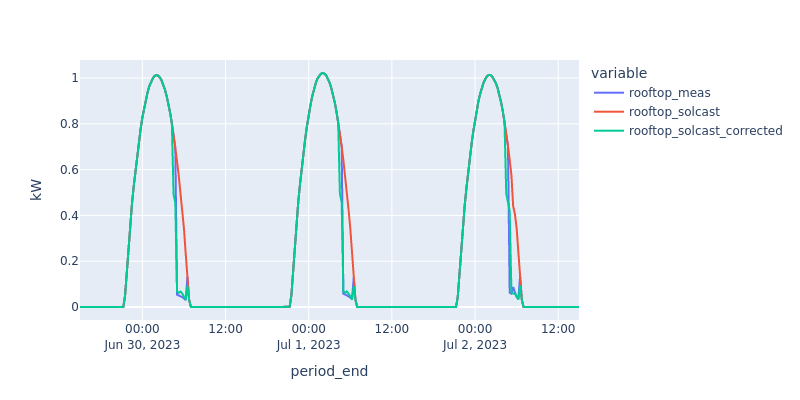

In [8]:
fig = px.line(df.loc["2023-06-29T15:00":"2023-07-02T15:00"], height=400, width=800)
fig.update_yaxes(title="kW")
fig.show()